<h1>Preprocessing and Seasonal Decomposition</h1>

In [1]:
# Miscellaneous:
import numpy as np
import pandas as pd

# Preprocessing and Statistical Functionality:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# PyTorch: 
import torch

# Testing:
import unittest
from RNN_tests import TestNormalisation, TestDenormalisation
from RNN_tests import TestTimeSeriesSequenceExtraction

# Seasonal Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

# Custom Function and Class Imports: 
from data_utils import normalise_dataframe, denormalise_data, create_time_sequences_and_targets_mv
from data_utils import generate_random_indices
from visualisations import plot_decomposition

# Data:
df = pd.read_csv("total_df_mv.csv")

try:
    df["pd_datetime"] = pd.to_datetime(df["time"], utc=True, errors="raise")
    df.set_index("pd_datetime", inplace=True)
except Exception as e:
    print(f"Error converting to datetime: {e}")

# Device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("\nGPU is available!")
else:
    device = torch.device("cpu")
    print("\nGPU not available. Running on CPU.")
    
# Important variables and column name adjustment: 
target_columns = ["total load actual", "generation solar", "generation wind onshore"]
    
exo_columns = ["avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", "avg_clouds_all"]

series_columns = ["total load actual", "generation solar", "generation wind onshore", "avg_temp", "avg_humidity", "avg_wind_speed", "avg_rain_1h", 
               "avg_clouds_all"]

column_name_mapping = {
    "total load actual": "load",
    "generation solar": "solar",
    "generation wind onshore": "wind"
}


GPU is available!


<h3>Normalise data</h3>

In [2]:
normalised_df, scaler_values = normalise_dataframe(df, series_columns)

print(f"\nscaler_values:\n{scaler_values}\n")

data = {}
for column, scaler in scaler_values.items():
    data[column] = [scaler.data_min_[0], scaler.data_max_[0]]

scalers_df = pd.DataFrame.from_dict(data, orient="index", columns=["Scaler_Min", "Scaler_Max"])

suite = unittest.TestLoader().loadTestsFromTestCase(TestNormalisation)
unittest.TextTestRunner(verbosity=2).run(suite)

test_normalisation_bounds (RNN_tests.TestNormalisation) ... ok
test_returned_columns_are_floats (RNN_tests.TestNormalisation) ... ok
test_returned_df_has_same_dimensions (RNN_tests.TestNormalisation) ... 


scaler_values:
{'total load actual': MinMaxScaler(), 'generation solar': MinMaxScaler(), 'generation wind onshore': MinMaxScaler(), 'avg_temp': MinMaxScaler(), 'avg_humidity': MinMaxScaler(), 'avg_wind_speed': MinMaxScaler(), 'avg_rain_1h': MinMaxScaler(), 'avg_clouds_all': MinMaxScaler()}



ok

----------------------------------------------------------------------
Ran 3 tests in 0.014s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

<h3>Attain Data and Targets</h3>

In [3]:
target_column_names = ["total load actual", "generation solar", "generation wind onshore"] 
target_column_indices = [normalised_df.columns.get_loc(col) for col in target_column_names]
sequence_length = 24 

# Extracting features, X, and targets, y:
X, y = create_time_sequences_and_targets_mv(normalised_df.values, target_column_indices, sequence_length)

print(f"Length of X: {len(X)}, shape: {X.shape}")
print(f"Length of y: {len(y)}, shape: {y.shape}")
print(f"\nNormalised columns: {normalised_df.columns}")

X_df = pd.DataFrame(X.reshape(X.shape[0], -1))  # Reshaping X to 2D for conversion to df.
y_df = pd.DataFrame(y, columns=target_column_names)

# Merging X_df and y_df: 
sequences_and_targets_df = pd.concat([X_df, y_df], axis=1)

# Note: For tests to pass, the variable being forecast must be in the first column. 
suite = unittest.TestLoader().loadTestsFromTestCase(TestTimeSeriesSequenceExtraction)
suite._tests[0].setUpClass(data=normalised_df.values)
unittest.TextTestRunner(verbosity=2).run(suite)

<h3>Seasonal Decomposition of Target Series</h3>


Decomposing total load actual:



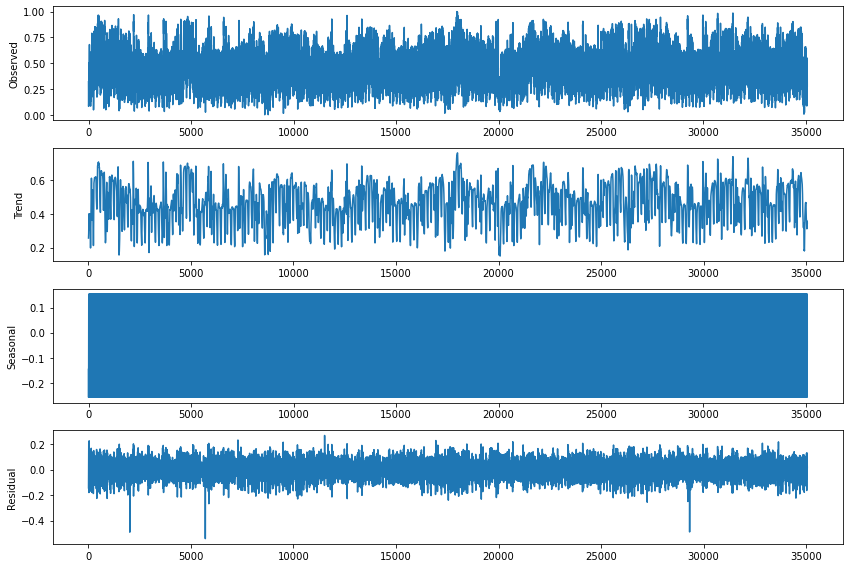


Residual length: 35040


Trend length: 35040


Seasonal length: 35064


Decomposing generation solar:



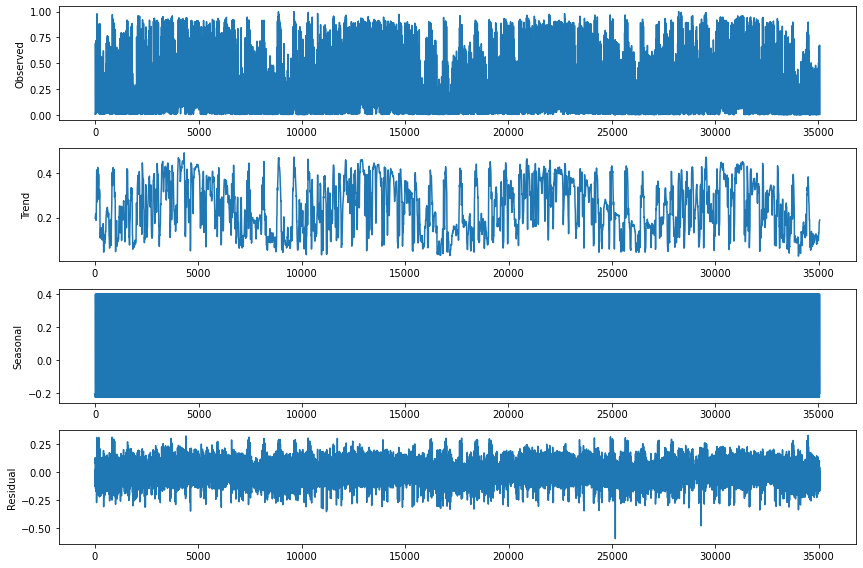


Residual length: 35040


Trend length: 35040


Seasonal length: 35064


Decomposing generation wind onshore:



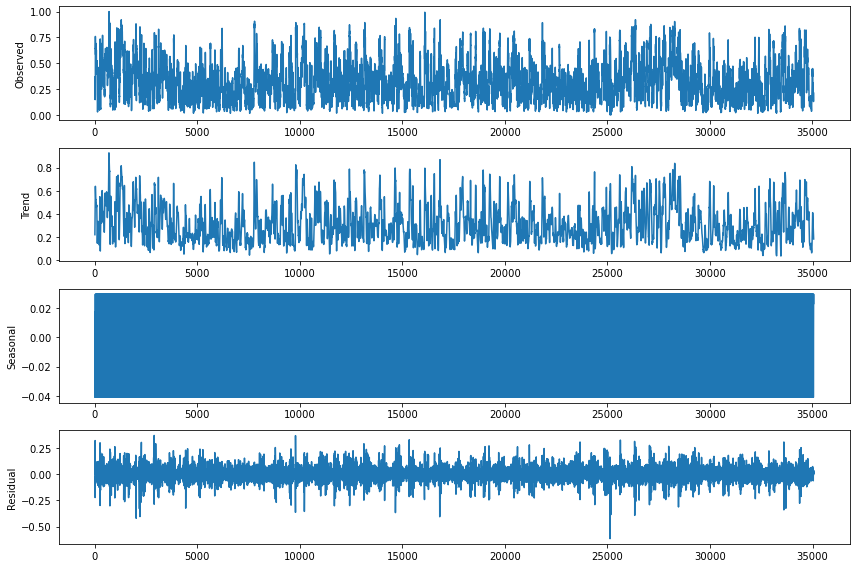


Residual length: 35040


Trend length: 35040


Seasonal length: 35064

Length of total load actual: 35040
Length of generation solar: 35040
Length of generation wind onshore: 35040
Length of avg_temp: 35040
Length of avg_humidity: 35040
Length of avg_wind_speed: 35040
Length of avg_rain_1h: 35040
Length of avg_clouds_all: 35040
Length of load_trend: 35040
Length of load_seasonal: 35040
Length of load_resid: 35040
Length of solar_trend: 35040
Length of solar_seasonal: 35040
Length of solar_resid: 35040
Length of wind_trend: 35040
Length of wind_seasonal: 35040
Length of wind_resid: 35040


In [4]:
period = 24

target_columns = ["total load actual", "generation solar", "generation wind onshore"]

for column in target_columns:
     
    result = seasonal_decompose(normalised_df[column], period=period, model="additive")
    
    shortened_name = column_name_mapping[column]
    
    normalised_df[f"{shortened_name}_trend"] = result.trend
    normalised_df[f"{shortened_name}_seasonal"] = result.seasonal
    normalised_df[f"{shortened_name}_resid"] = result.resid
    
period = 24
target_columns = ["total load actual", "generation solar", "generation wind onshore"]

for column in target_columns:
    print(f"\nDecomposing {column}:\n")
    
    # In an additive model, components are added rather than multiplied
    # A multiplative model would be for something like suspension displacement after a bump on a road.
    result = seasonal_decompose(normalised_df[column], model="additive", period=period)
    
    plot_decomposition(result)
    
    shortened_name = column_name_mapping[column]
    
    normalised_df[f"{shortened_name}_trend"] = result.trend
    normalised_df[f"{shortened_name}_seasonal"] = result.seasonal
    normalised_df[f"{shortened_name}_resid"] = result.resid
    
    #print(f"Residual:\n{result.resid.dropna()}")
    print(f"\nResidual length: {len(result.resid.dropna())}\n")
    
    #print(f"Trend:\n{result.trend.dropna()}")
    print(f"\nTrend length: {len(result.trend.dropna())}\n")
    
    #print(f"Seasonal:\n{result.seasonal.dropna()}")
    print(f"\nSeasonal length: {len(result.seasonal.dropna())}\n")


normalised_df.dropna(inplace=True)

# Checking and printing lengths:
column_lengths = {col: len(normalised_df[col]) for col in normalised_df.columns}
for col, length in column_lengths.items():
    print(f"Length of {col}: {length}")

# Asserting that all columns have the same length:
assert len(set(column_lengths.values())) == 1, "There is a mismatch in column length."


<h3>Output Dataframe with decomposed, trimmed, normalised values, scalers etc.</h3>

In [5]:
normalised_df.to_csv("decomposed_dataframe.csv", index=False)
scalers_df.to_csv("scaler_values.csv")
# sequences_and_targets_df.to_csv("TEST_sequences_targets_dataframe.csv", index=False)

# All data here will then be imported to LSTM files that use it. 